**TODO :**
- Augmentations
- LAB normalization ?

In [17]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [18]:
import os
import sys
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

In [124]:
from params import *

from data.transforms import HE_preprocess
from data.dataset import TileDataset

from model_zoo.models import define_model

from training.main import k_fold
from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

from utils.plots import plot_contours

### Load

In [20]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + "df_images.csv")

## Data

In [131]:
viz_ds = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=True),
)

In [132]:
i = 40
img, mask = viz_ds[i]
img = img.permute(1, 2, 0).numpy()

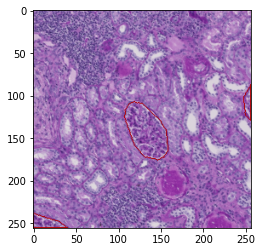

In [133]:
_ = plot_contours(img.copy(), mask.numpy())

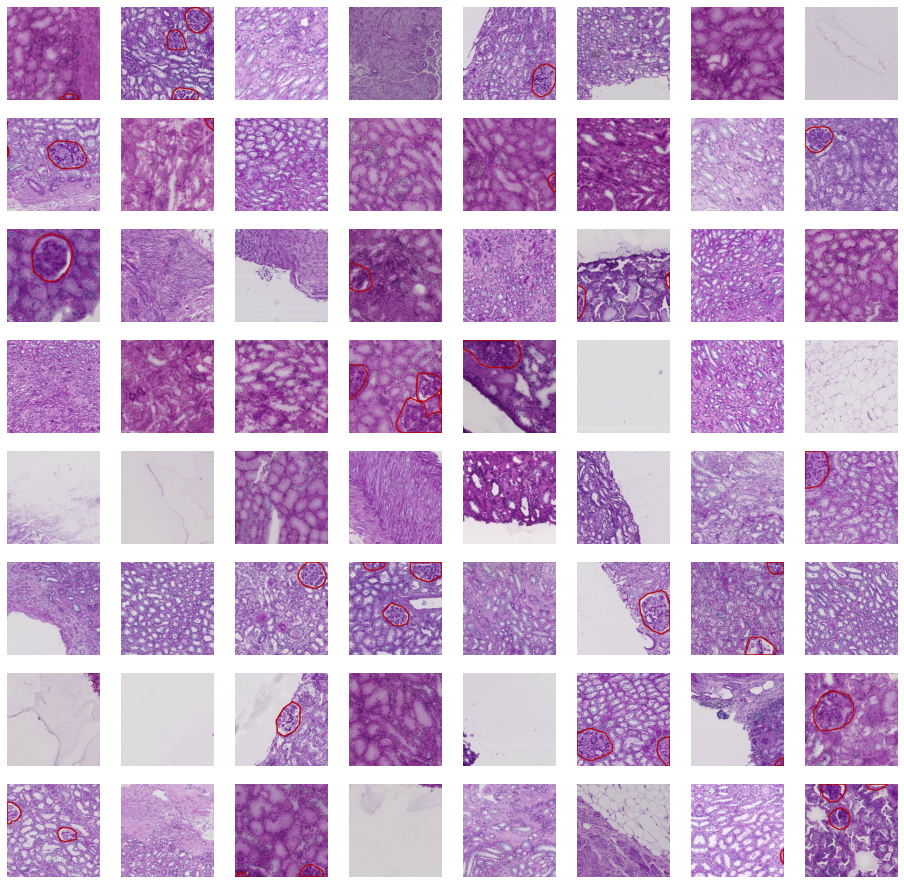

In [134]:
viz_dl = DataLoader(viz_ds, batch_size=64, shuffle=True)
imgs, masks = next(iter(viz_dl))

plt.figure(figsize=(16, 16))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img.permute(1, 2, 0).numpy()  # .astype(np.uint8)
    plt.subplot(8, 8, i + 1)
    
    plot_contours(img.copy(), mask.numpy(), w=2)
    plt.axis("off")
    plt.subplots_adjust(wspace=None, hspace=None)

## Model

In [7]:
from training.lovasz import *

In [8]:
dataset = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=False),
)

In [9]:
model = define_model("Unet", "resnet18")

In [10]:
img, y = dataset[0]

In [11]:
pred = model(img.unsqueeze(0))

In [12]:
symmetric_lovasz(pred, y.unsqueeze(0))

tensor([11.6503], grad_fn=<DivBackward0>)

## Training

In [13]:
BATCH_SIZES = {
    "resnet34": 32, 
    "resnext50_32x4d": 32, 
    "se_resnext50_32x4d": 32,
    "efficientnet-b4": 32,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [14]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    img_dir = IMG_PATH
    mask_dir = MASK_PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    cv_column = "4fold"
    random_state = 0
    selected_folds = [0]  # [0, 1, 2, 3]

    # Model
    encoder = "efficientnet-b5"  # resnext50_32x4d, "resnet34", "se_resnext50_32x4d"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    encoder_weights = "imagenet"
    num_classes = 1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    batch_size = BATCH_SIZES[encoder]
    
    if batch_size == 32:
        epochs = 40
    elif batch_size == 16:
        epochs = 30
    elif batch_size == 8:
        epochs = 20
    
    lr = 1e-3
    swa_first_epoch = 50

    warmup_prop = 0.05
    val_bs = batch_size * 2

    first_epoch_eval = 0

    # Inference
    overlap_factor = 2

Best models : 
- se_resnext50_32x4d : logs/2020-12-21/3
- b4 : logs/2020-12-22/9/
- b5 : logs/2020-12-22/10/

In [15]:
DEBUG = False
log_folder = None

In [16]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    df.to_csv(log_folder + "data.csv", index=False)
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold(Config, df, log_folder=log_folder)

Logging results to ../logs/2020-12-23/4/

-------------   Fold 1 / 4  -------------

    -> 3482 training images
    -> 489 validation images
    -> 20225689 trainable parameters

Epoch 01/30 	 lr=6.7e-04	 t=58s	loss=0.256	val_loss=0.050 	 dice=0.8313
Epoch 02/30 	 lr=9.8e-04	 t=57s	loss=0.043	val_loss=0.025 	 dice=0.8173
Epoch 03/30 	 lr=9.5e-04	 t=56s	loss=0.030	val_loss=0.030 	 dice=0.7653
Epoch 04/30 	 lr=9.1e-04	 t=56s	loss=0.027	val_loss=0.042 	 dice=0.8011
Epoch 05/30 	 lr=8.8e-04	 t=56s	loss=0.026	val_loss=0.018 	 dice=0.8762
Epoch 06/30 	 lr=8.4e-04	 t=57s	loss=0.023	val_loss=0.016 	 dice=0.8824
Epoch 07/30 	 lr=8.1e-04	 t=57s	loss=0.022	val_loss=0.015 	 dice=0.8668
Epoch 08/30 	 lr=7.7e-04	 t=57s	loss=0.022	val_loss=0.036 	 dice=0.7115
Epoch 09/30 	 lr=7.4e-04	 t=56s	loss=0.021	val_loss=0.016 	 dice=0.8866
Epoch 10/30 	 lr=7.0e-04	 t=57s	loss=0.022	val_loss=0.018 	 dice=0.8835
Epoch 11/30 	 lr=6.7e-04	 t=56s	loss=0.020	val_loss=0.015 	 dice=0.8986
Epoch 12/30 	 lr=6.3e-04	 t=